In [25]:
import pandas as pd
import gensim
import nltk
import re
import string
from sentiment_module import sentiment
import statistics as stat
import pyLDAvis.gensim
import matplotlib.pyplot as plt

Looking at the first 10,000 obs

In [26]:
twt_5k = pd.read_csv("../data/dave_1_5000_tweet_1.csv")
twt_10k = pd.read_csv("../data/dave_5001_10000_tweet_1.csv")

In [27]:
qing = pd.read_csv("../data/Qing_10000_tweet.csv")
ryan = pd.read_csv("../data/ryan_1_10000_tweet.csv")

Combining into one dataframe

In [28]:
twt = pd.concat([twt_5k, twt_10k, qing, ryan])
len(twt)

30020

Filtering retweets from dataset

In [29]:
og_twt = twt['retweet']==0   #retweet is a column name
twt_no_rt = twt[og_twt]
print(twt_no_rt['body'].head(n=10))  #body is a column name

6                                           Iphone XS 😩
9     SMART GADGETS ELECTRONICS PVT LTD  #USDCASH SA...
10    @s_sprimuss I've used the Iphone Xs for two we...
15    Apple iPhone XS and XS MAX Review https://t.co...
17    eBay: Apple iPhone XS Max - 512GB - Space Grey...
18    Google Pixel 3 and Pixel 3 XL are here to take...
19    IPhone X;Iphone XS; IPhone XR; IPhone 6s; IPho...
24    iDrop News is giving away a free iPhone XS Max...
28    The iPhone XR Is Depressing... https://t.co/gk...
29    The iPhone XR Is Depressing... https://t.co/gk...
Name: body, dtype: object


In [30]:
tweets = twt_no_rt['body'].tolist() #.tolist() Return the array as a (possibly nested) list.
print(len(tweets))

7791


In [31]:
tweets_df = pd.DataFrame({'tweets':tweets})
tweets_df.to_csv("../data/clean_tweets.csv")

Remove punctuation, then tokenize documents

In [36]:
punc = re.compile( '[%s]' % re.escape( string.punctuation ) )
term_vec = [ ]

for t in tweets:
    t = t.lower()
    t = punc.sub( '', t )
    term_vec.append( nltk.word_tokenize( t ) )

print(len(term_vec))

7791


Removing tweets with promotional words  

In [51]:
promo = pd.read_csv("promo_words.csv", header=None)
promo = list(promo.iloc[0])
promo = [i.strip() for i in promo]

In [52]:
for idx, t in enumerate(term_vec):
    if any([elem in promo for elem in t]):
        del term_vec[idx]
        
print(len(term_vec))

6524


Print resulting term vectors

Remove stop words from term vectors

In [53]:
stop_words = nltk.corpus.stopwords.words( 'english' )
iphone_words = ['iphone', 'max', 'xs', 'xr', 'iphonexs', 'iphonexr', "’"]
for i in iphone_words:
    stop_words.append(i)

for i in range( 0, len( term_vec ) ):
    term_list = [ ]

    for term in term_vec[ i ]:
        if term not in stop_words:
            term_list.append( term )

    term_vec[ i ] = term_list

Print term vectors with stop words removed

In [55]:
len(term_vec)

6524

Porter stem remaining terms

In [56]:
porter = nltk.stem.porter.PorterStemmer()

for i in range( 0, len( term_vec ) ):
    for j in range( 0, len( term_vec[ i ] ) ):
        term_vec[ i ][ j ] = porter.stem( term_vec[ i ][ j ] )

Print term vectors with stop words removed

Convert term vectors into gensim dictionary

In [57]:
dict = gensim.corpora.Dictionary( term_vec )

corp = [ ]
for i in range( 0, len( term_vec ) ):
    corp.append( dict.doc2bow( term_vec[ i ] ) )

Create TFIDF vectors based on term vectors bag-of-word corpora

In [58]:
tfidf_model = gensim.models.TfidfModel( corp )

tfidf = [ ]
for i in range( 0, len( corp ) ):
    tfidf.append( tfidf_model[ corp[ i ] ] )

Create pairwise document similarity index

In [59]:
n = len( dict )
index = gensim.similarities.SparseMatrixSimilarity( tfidf_model[ corp ], num_features = n )

Print TFIDF vectors and pairwise similarity per document

Building lists for arousal and valence for the average of each tweet

In [61]:
total_arousal = []
total_valence = []

for i in term_vec:
    sent = sentiment.sentiment(i)
    total_arousal.append(sent['arousal'])
    total_valence.append(sent['valence'])

Calculating the average of all the tweets

In [62]:
print("Average arousal is", stat.mean(total_arousal))
print("Average valence is", stat.mean(total_valence))


Average arousal is 4.136572476571285
Average valence is 5.467436676430132


Need to plot sentiment

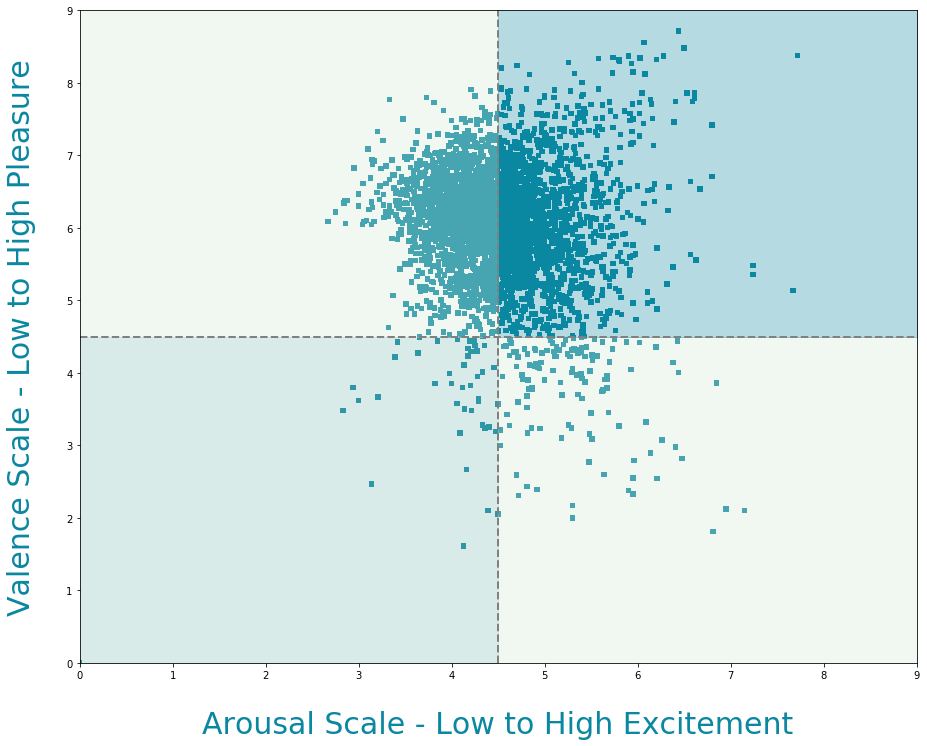

In [90]:
z = 4.5

fig,ax = plt.subplots(figsize=(15,12))
ax.set_xlim(0,9)
ax.set_ylim(0,9)

ax.scatter(total_arousal, total_valence, marker='s', s=30, c='#0A87A1', edgecolors='', lw=1)

ax.axvline(z,color = 'grey',linestyle='dashed',lw=2)
ax.axhline(z,color = 'grey',linestyle='dashed',lw=2)

ax.fill_between([0, z],0,z, alpha=0.3, color='#80BFB7')
ax.fill_between([z, 9], 0, z, alpha=0.3, color='#D2EBD5')  
ax.fill_between([0, z], z, 9, alpha=0.3, color='#D2EBD5') 
ax.fill_between([z, 9], z, 9, alpha=0.3, color='#0A87A1')  

plt.ylabel('Valence Scale - Low to High Pleasure', fontsize=30,labelpad=30, color='#0A87A1')
plt.xlabel('Arousal Scale - Low to High Excitement', fontsize=30,labelpad=30, color='#0A87A1')
#plt.title('Sentiment Analysis of iPhone Tweets', fontsize=40, pad=30, color='#0A87A1')
plt.show()

Building corpus for GenSim dictionary

In [28]:
corpus = [dict.doc2bow(text) for text in term_vec]

In [89]:
ldamodel5 = gensim.models.ldamodel.LdaModel(corpus, num_topics = 5, id2word=dict, passes=15)
ldamodel5.save('models/model5.gensim')

In [47]:
ldamodel20 = gensim.models.ldamodel.LdaModel(corpus, num_topics = 20, id2word=dict, passes=15)
ldamodel20.save('models/model20.gensim')

In [53]:
ldamodel3 = gensim.models.ldamodel.LdaModel(corpus, num_topics = 3, id2word=dict, passes=30)
ldamodel3.save('models/model3.gensim')

In [52]:
topics = ldamodel3.get_topics()
terms = ldamodel3.get_topic_terms(topicid=0)

#print(terms)
print(topics[2][1:30])

[1.40496204e-05 2.28380528e-03 1.38194227e-05 1.40690745e-05
 2.34370795e-03 1.17885320e-04 8.44721741e-04 1.40690745e-05
 1.40690745e-05 8.08821642e-04 5.54801384e-03 9.89352819e-04
 8.96723475e-03 1.95764922e-04 3.32124655e-05 3.32124655e-05
 5.65647439e-04 1.99934148e-04 1.44810538e-05 1.34750408e-05
 1.34988586e-05 1.40551656e-05 1.35188156e-05 1.34756174e-05
 1.34756174e-05 1.66262180e-05 1.47968822e-05 1.37848065e-05
 1.36596946e-05]


In [135]:
dir(ldamodel3)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__ignoreds',
 '__init__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__numpys',
 '__recursive_saveloads',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__scipys',
 '__setattr__',
 '__sizeof__',
 '__slotnames__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_adapt_by_suffix',
 '_apply',
 '_load_specials',
 '_save_specials',
 '_smart_save',
 'alpha',
 'bound',
 'callbacks',
 'chunksize',
 'clear',
 'decay',
 'diff',
 'dispatcher',
 'distributed',
 'do_estep',
 'do_mstep',
 'dtype',
 'eta',
 'eval_every',
 'expElogbeta',
 'gamma_threshold',
 'get_document_topics',
 'get_term_topics',
 'get_topic_terms',
 'get_topics',
 'id2word',
 'inference',
 'init_dir_prior',
 'iterations',
 'load',
 'log_perplexity',
 'minimum_phi_value',
 'minimum_probability',
 'num_terms',
 'num_topics',
 'num_updates',
 'nu

In [148]:
ldamodel3.print_topic(topicno=0)

'0.027*"case" + 0.026*"youtub" + 0.020*"video" + 0.018*"like" + 0.013*"via" + 0.011*"review" + 0.008*"sale" + 0.008*"appl" + 0.007*"x" + 0.007*"sell"'

In [54]:
lda = gensim.models.ldamodel.LdaModel.load('models/model3.gensim')
lda_display = pyLDAvis.gensim.prepare(lda, corpus, dict, sort_topics=True)

/usr/local/anaconda3/lib/python3.5/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [55]:
pyLDAvis.display(lda_display)

In [34]:
pyLDAvis.show(lda_display)


Note: if you're in the IPython notebook, pyLDAvis.show() is not the best command
      to use. Consider using pyLDAvis.display(), or pyLDAvis.enable_notebook().
      See more information at http://pyLDAvis.github.io/quickstart.html .

You must interrupt the kernel to end this command

Serving to http://127.0.0.1:8889/    [Ctrl-C to exit]


127.0.0.1 - - [18/Oct/2018 21:01:18] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [18/Oct/2018 21:01:18] "GET /LDAvis.css HTTP/1.1" 200 -
127.0.0.1 - - [18/Oct/2018 21:01:18] "GET /d3.js HTTP/1.1" 200 -
127.0.0.1 - - [18/Oct/2018 21:01:18] "GET /LDAvis.js HTTP/1.1" 200 -
127.0.0.1 - - [18/Oct/2018 21:01:19] code 404, message Not Found
127.0.0.1 - - [18/Oct/2018 21:01:19] "GET /favicon.ico HTTP/1.1" 404 -



stopping Server...
